In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sqlalchemy import create_engine
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler

import pyodbc

In [5]:
conn = pyodbc.connect(
    r'DRIVER={ODBC Driver 17 for SQL Server};'
    r'SERVER=DESKTOP-353OF77\SQLEXPRESS01;'
    r'DATABASE=DWH_SAP;'
    r'UID=sa;'
    r'PWD=2002'
)

In [6]:
def sql_to_df(query):
    """Fonction générique pour exécuter des requêtes SQL"""
    return pd.read_sql(query, conn)

In [7]:
req_fournisseurs = """
SELECT 
    [pk_supplier],
    [supplier_id],
    [supplier_name],
    [environmental_certifications],
    [renewable_energy_percentage],
    [sustainability_program]
FROM [dbo].[Dim_Fournisseurs]
WHERE [renewable_energy_percentage] IS NOT NULL
"""

# Récupération des données
df_fournisseurs = sql_to_df(req_fournisseurs)

# Affichage pour vérification
print(df_fournisseurs.head())

   pk_supplier supplier_id             supplier_name  \
0            1  SUPPLIER_1         Laiterie Centrale   
1            2  SUPPLIER_2  Agro-Alimentaire Tunisie   
2            3  SUPPLIER_3     Import-Export Naturel   
3            4  SUPPLIER_4         Qualité Fraîcheur   
4            5  SUPPLIER_5         Fruits et Saveurs   

  environmental_certifications renewable_energy_percentage  \
0       Agriculture Biologique                       32,09   
1                       Aucune                       59,61   
2                    ISO 14001                       99,57   
3                       Aucune                       43,53   
4                       Aucune                       92,07   

  sustainability_program  
0                    Oui  
1                    Non  
2                    Non  
3                    Non  
4                    Oui  


C:\Users\TAREK\AppData\Local\Temp\ipykernel_11812\424510669.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


In [199]:
print("Nombre total de lignes :", len(df_fournisseurs))


Nombre total de lignes : 83


Lignes totales : 83, valeurs invalides : 0

Aperçu après nettoyage :
   pk_supplier  supplier_id  supplier_name  environmental_certifications  \
0            1            0             34                             0   
1            2           11              1                             1   
2            3           22             31                             2   
3            4           33             49                             1   
4            5           44             28                             1   

   renewable_energy_percentage  sustainability_program  
0                        32.09                       1  
1                        59.61                       0  
2                        99.57                       0  
3                        43.53                       0  
4                        92.07                       1  

Types de colonnes :
pk_supplier                       int64
supplier_id                       int64
supplier_name                  

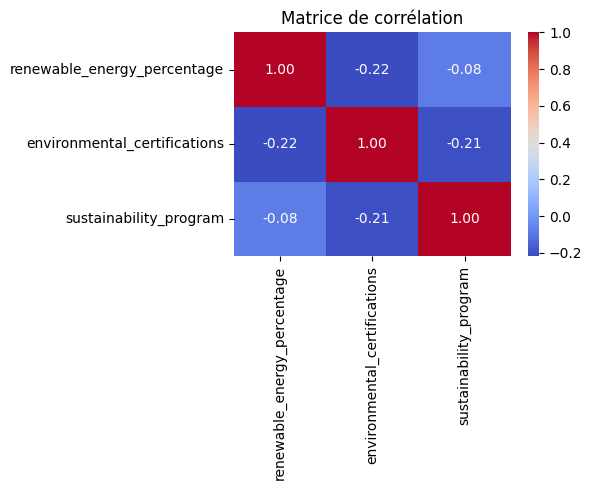

In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# — 1. Extraction et conversion en float —
# On capture la partie numérique (avec ou sans décimales)
extracted = (
    df_fournisseurs['renewable_energy_percentage']
        .astype(str)
        .str.extract(r'(\d+[.,]?\d*)')   # ex. "32,09" ou "99"
)
# Remplace la virgule par le point et convertit en float
df_fournisseurs['renewable_energy_percentage'] = pd.to_numeric(
    extracted[0].str.replace(',', '.', regex=False),
    errors='coerce'
)

# — 2. Diagnostic : combien de NaN ?
n_total   = len(df_fournisseurs)
n_missing = df_fournisseurs['renewable_energy_percentage'].isna().sum()
print(f"Lignes totales : {n_total}, valeurs invalides : {n_missing}")

# — 3. Stratégie de remplissage ou de suppression —
# Si moins de 10% de NaN, on remplit à la moyenne ; sinon on droppe ces lignes
if n_missing > 0:
    if n_missing / n_total < 0.10:
        mean_val = df_fournisseurs['renewable_energy_percentage'].mean()
        df_fournisseurs = df_fournisseurs.assign(
            renewable_energy_percentage = 
                df_fournisseurs['renewable_energy_percentage'].fillna(mean_val)
        )
    else:
        df_fournisseurs = df_fournisseurs.dropna(
            subset=['renewable_energy_percentage']
        )

# — 4. Encodage des catégorielles —
le = LabelEncoder()
for col in ['supplier_id', 'supplier_name', 'environmental_certifications', 'sustainability_program']:
    df_fournisseurs[col] = le.fit_transform(df_fournisseurs[col].astype(str))

# — 5. Inspection finale —
print("\nAperçu après nettoyage :")
print(df_fournisseurs.head())
print("\nTypes de colonnes :")
print(df_fournisseurs.dtypes)

# — 6. Génération et affichage de la matrice de corrélation —
# On ne garde que les colonnes numériques réellement pertinentes
cols_corr = [
    'renewable_energy_percentage',
    'environmental_certifications',
    'sustainability_program'
]
corr_matrix = df_fournisseurs[cols_corr].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.tight_layout()
plt.show()


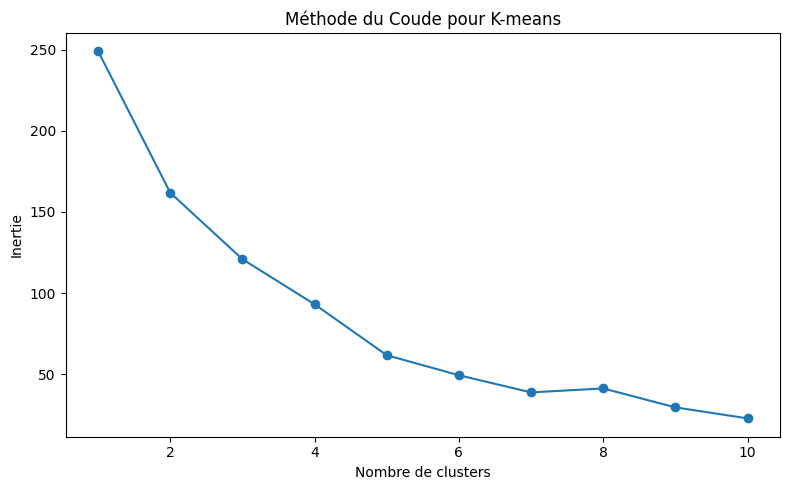

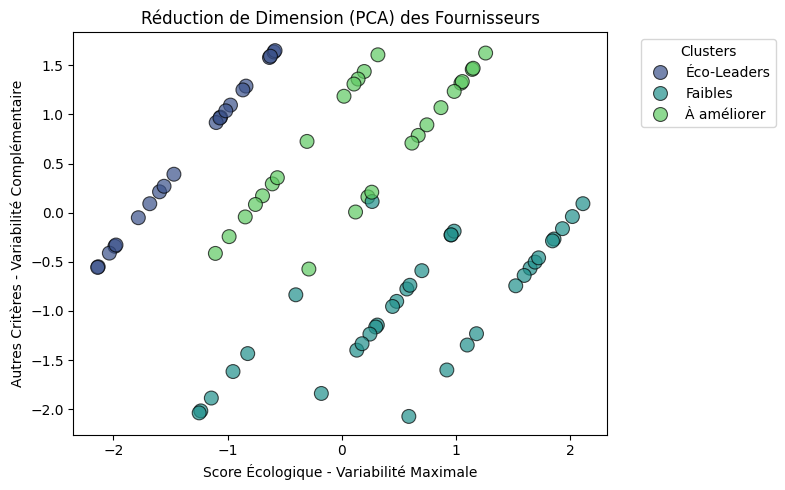

   renewable_energy_percentage  environmental_certifications  \
0                        32.09                             0   
1                        59.61                             1   
2                        99.57                             2   
3                        43.53                             1   
4                        92.07                             1   

   sustainability_program  cluster cluster_label  
0                       1        2   Éco-Leaders  
1                       0        0       Faibles  
2                       0        0       Faibles  
3                       0        0       Faibles  
4                       1        1   À améliorer  
   renewable_energy_percentage  environmental_certifications  \
0                        32.09                             0   
1                        59.61                             1   
2                        99.57                             2   
3                        43.53                       

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

# --------------------------------------------------------------------------------
# 2. Clustering K-means
# --------------------------------------------------------------------------------

# Sélection des variables pertinentes pour le clustering
X = df_fournisseurs[['renewable_energy_percentage', 'environmental_certifications', 'sustainability_program']]

# Encodage des variables qualitatives
X_encoded = pd.get_dummies(X, drop_first=False)

# Normalisation des données pour éviter que certaines variables dominent
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Déterminer le nombre de clusters avec la méthode du coude
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Afficher la courbe du coude pour déterminer le meilleur k
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Méthode du Coude pour K-means')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.tight_layout()
plt.show()

# Choisir k = 3 basé sur la courbe du coude
kmeans = KMeans(n_clusters=3, random_state=42)
df_fournisseurs['cluster'] = kmeans.fit_predict(X_scaled)

# Création des labels de clusters
cluster_labels = {0: 'Faibles', 1: 'À améliorer', 2: 'Éco-Leaders'}
df_fournisseurs['cluster_label'] = df_fournisseurs['cluster'].map(cluster_labels)

# --------------------------------------------------------------------------------
# 3. PCA pour visualiser en 2D
# --------------------------------------------------------------------------------

# Appliquer la PCA pour réduire la dimensionnalité à 2 composantes principales
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Créer un DataFrame avec les résultats PCA
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])

# Ajouter les résultats PCA au DataFrame original (df_fournisseurs)
df_fournisseurs[['PCA1', 'PCA2']] = pca_df[['PCA1', 'PCA2']]

# Visualisation des clusters en 2D avec labels
plt.figure(figsize=(8, 5))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster_label', data=df_fournisseurs, palette='viridis', s=100, alpha=0.7, edgecolor='black')
plt.title("Réduction de Dimension (PCA) des Fournisseurs")
plt.xlabel("Score Écologique - Variabilité Maximale")
plt.ylabel("Autres Critères - Variabilité Complémentaire")
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Afficher les résultats du clustering avec les labels
print(df_fournisseurs[['renewable_energy_percentage', 'environmental_certifications', 'sustainability_program', 'cluster', 'cluster_label']].head())
# Afficher les scores PCA (PCA1 et PCA2) avec les clusters et labels
print(df_fournisseurs[['renewable_energy_percentage', 'environmental_certifications', 'sustainability_program', 'PCA1', 'PCA2', 'cluster', 'cluster_label']].head())
# Afficher tout le DataFrame avec les scores PCA, clusters et labels
print(df_fournisseurs)
from sklearn.metrics import silhouette_score

# 1. Calcul de l'inertie pour K-means
inertia = kmeans.inertia_
print(f"Inertie (SSE) du modèle K-means : {inertia}")

# 2. Calcul du Silhouette Score
silhouette_avg = silhouette_score(X_scaled, df_fournisseurs['cluster'])
print(f"Silhouette Score du modèle K-means : {silhouette_avg}")



Test eps=0.3 → 10 cluster(s)
Test eps=0.5 → 8 cluster(s)
Test eps=0.8 → 6 cluster(s)
Test eps=1.0 → 6 cluster(s)
Test eps=1.2 → 6 cluster(s)
Test eps=1.5 → 2 cluster(s)
Test eps=2.0 → 2 cluster(s)
⚠️ Aucun eps trouvé donnant exactement 3 clusters, on garde la dernière config


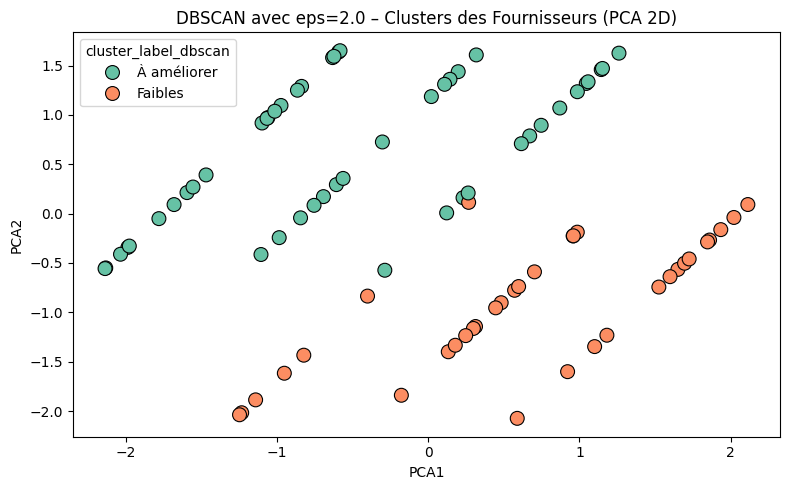

✅ Silhouette Score (DBSCAN) : 0.3630
✅ Silhouette Score (KMeans) : 0.3644


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score

# --------------------------------------------------------------------------------
# 1. Préparation des données
# --------------------------------------------------------------------------------

X = df_fournisseurs[['renewable_energy_percentage', 'environmental_certifications', 'sustainability_program']]
X_encoded = pd.get_dummies(X, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Réduction pour DBSCAN
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_scaled)

# --------------------------------------------------------------------------------
# 2. DBSCAN avec recherche de eps donnant 3 clusters
# --------------------------------------------------------------------------------

eps_values = [0.3, 0.5, 0.8, 1.0, 1.2, 1.5, 2.0]
best_eps = None
best_labels = None

for eps_chosen in eps_values:
    dbscan = DBSCAN(eps=eps_chosen, min_samples=4)
    labels = dbscan.fit_predict(X_reduced)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"Test eps={eps_chosen} → {n_clusters} cluster(s)")
    
    if n_clusters == 3:
        best_eps = eps_chosen
        best_labels = labels
        break

if best_eps is None:
    print("⚠️ Aucun eps trouvé donnant exactement 3 clusters, on garde la dernière config")
    best_eps = eps_values[-1]
    dbscan = DBSCAN(eps=best_eps, min_samples=4)
    best_labels = dbscan.fit_predict(X_reduced)

# Application des meilleurs résultats
df_fournisseurs['cluster_dbscan'] = best_labels
n_clusters = len(set(best_labels)) - (1 if -1 in best_labels else 0)

# --------------------------------------------------------------------------------
# 3. Attribution des labels intelligents
# --------------------------------------------------------------------------------

if n_clusters >= 2:
    if n_clusters >= 3:
        cluster_means = df_fournisseurs.groupby('cluster_dbscan')['renewable_energy_percentage'].mean().sort_values()
        labels = ['Faibles', 'À améliorer', 'Éco-Leaders'][:n_clusters]
        mapping = {cluster: label for cluster, label in zip(cluster_means.index, labels)}
        df_fournisseurs['cluster_label_dbscan'] = df_fournisseurs['cluster_dbscan'].map(mapping)
    else:
        df_fournisseurs['score_sustainability'] = (
            df_fournisseurs['renewable_energy_percentage'] +
            df_fournisseurs['environmental_certifications'] * 20 +
            df_fournisseurs['sustainability_program'] * 20
        )
        cluster_scores = df_fournisseurs.groupby('cluster_dbscan')['score_sustainability'].mean()
        cluster_ordered = cluster_scores.sort_values().index
        label_names = ['Faibles', 'À améliorer', 'Éco-Leaders']
        mapping = {cluster: label for cluster, label in zip(cluster_ordered[:3], label_names)}
        df_fournisseurs['cluster_label_dbscan'] = df_fournisseurs['cluster_dbscan'].map(
            lambda x: mapping.get(x, 'Bruit')
        )
else:
    df_fournisseurs['cluster_label_dbscan'] = 'Bruit'

# --------------------------------------------------------------------------------
# 4. Visualisation
# --------------------------------------------------------------------------------

pca_final = PCA(n_components=2)
X_pca2d = pca_final.fit_transform(X_scaled)
df_fournisseurs[['PCA1', 'PCA2']] = X_pca2d

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_fournisseurs, x='PCA1', y='PCA2', hue='cluster_label_dbscan', palette='Set2', s=100, edgecolor='black')
plt.title(f"DBSCAN avec eps={best_eps} – Clusters des Fournisseurs (PCA 2D)")
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------------
# 5. Évaluation (DBSCAN vs KMeans)
# --------------------------------------------------------------------------------

mask = df_fournisseurs['cluster_dbscan'] != -1
if mask.sum() > 1 and len(set(df_fournisseurs.loc[mask, 'cluster_dbscan'])) > 1:
    silhouette_dbscan = silhouette_score(X_scaled[mask], df_fournisseurs.loc[mask, 'cluster_dbscan'])
    print(f"✅ Silhouette Score (DBSCAN) : {silhouette_dbscan:.4f}")
else:
    print("❌ Trop peu de points pour un Silhouette Score fiable (DBSCAN)")

# Comparatif avec KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df_fournisseurs['cluster_kmeans'] = kmeans.fit_predict(X_scaled)
silhouette_kmeans = silhouette_score(X_scaled, df_fournisseurs['cluster_kmeans'])
print(f"✅ Silhouette Score (KMeans) : {silhouette_kmeans:.4f}")


In [17]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import joblib

# Charger tes données
df = pd.read_excel('C:\\Users\\TAREK\\Desktop\\Classeur1.xlsx')

# Sélectionner les variables
X = df[['renewable_energy_percentage', 'environmental_certifications', 'sustainability_program']]
X_encoded = pd.get_dummies(X, drop_first=True)

# Sauvegarder les noms des colonnes pour vérification future
feature_names = X_encoded.columns.tolist()

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# KMeans (3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

# Sauvegarde du scaler et du modèle
joblib.dump(scaler, 'C:/Users/TAREK/Desktop/scaler.pkl')
joblib.dump(kmeans, 'C:/Users/TAREK/Desktop/model.pkl')

['C:/Users/TAREK/Desktop/model.pkl']

In [204]:
import pickle

# Sauvegarder le modèle KMeans
with open('model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

# Sauvegarder le StandardScaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Modèle et scaler enregistrés dans 'model.pkl' et 'scaler.pkl'")


Modèle et scaler enregistrés dans 'model.pkl' et 'scaler.pkl'


In [202]:
import pickle

# Exemple : modèle fictif
model = {'example': 'This is a sample model'}

# Sauvegarder le modèle
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Le modèle a été enregistré sous 'model.pkl'.")

Le modèle a été enregistré sous 'model.pkl'.


In [205]:
pip install scikit-learn==1.6.1


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [194]:
from IPython.display import FileLink

# Afficher un lien de téléchargement pour le fichier model.pkl
FileLink('model.pkl')

c:\Users\TAREK\Downloads\model.pkl

In [147]:
# 2. OBJECTIF CLASSIFICATION (Notifications)
req_notifications = """
SELECT 
    [pk_notification],
    [category],
    [description],
    [priority],
    [timestamp]
FROM [dbo].[Dim_Alert_Management]
WHERE [priority] IN ('Élevée', 'Critique', 'Moyenne', 'Faible')
"""
# Récupération des données
df_notifications = sql_to_df(req_notifications)

# Affichage pour vérification
print(df_notifications.head())

   pk_notification                  category  \
0                1               Fournisseur   
1                2                  Matériel   
2                3                     Stock   
3                4  Catégorie Pas disponible   
4                5                  Matériel   

                                         description  priority  \
0                         Description Pas disponible    Élevée   
1      Stock critique détecté pour le matériel M117.  Critique   
2  Suppression impossible en raison de restrictions.   Moyenne   
3  Le fournisseur SUPPLIER_5 n'a pas répondu à un...    Faible   
4                         Description Pas disponible    Faible   

                timestamp  
0 2024-10-29 09:14:22.527  
1 2023-10-14 14:15:00.000  
2 2023-10-13 10:05:00.000  
3 2023-10-12 16:45:00.000  
4 2024-02-07 16:36:41.030  


C:\Users\TAREK\AppData\Local\Temp\ipykernel_16596\424510669.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)



Random Forest:

              precision    recall  f1-score   support

    Critique       0.90      0.82      0.86        11
      Faible       0.50      0.67      0.57         3
     Moyenne       0.00      0.00      0.00         1

   micro avg       0.79      0.73      0.76        15
   macro avg       0.47      0.49      0.48        15
weighted avg       0.76      0.73      0.74        15


XGBoost:

              precision    recall  f1-score   support

    Critique       1.00      0.82      0.90        11
      Faible       0.50      1.00      0.67         3
     Moyenne       0.00      0.00      0.00         1

    accuracy                           0.80        15
   macro avg       0.50      0.61      0.52        15
weighted avg       0.83      0.80      0.79        15


Logistic Regression:

              precision    recall  f1-score   support

    Critique       0.90      0.82      0.86        11
      Faible       0.50      0.67      0.57         3
     Moyenne       0.00 

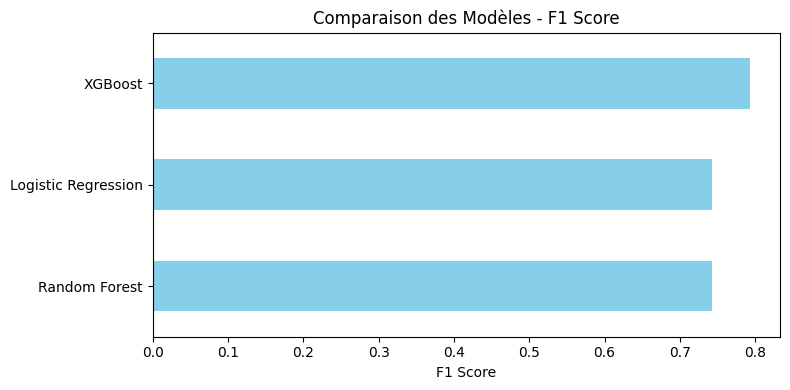

In [187]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Préparation des données
X = pd.get_dummies(df_notifications[['category', 'description']])
y = df_notifications['priority']

# 2. Encodage intelligent de la cible
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 3. Split des données en conservant la distribution des classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.3, 
    random_state=42,
    stratify=y_encoded  # Conservation des proportions
)

# 4. Détection des classes réellement présentes dans y_train
train_classes = np.unique(y_train)
target_names = [le.inverse_transform([cls])[0] for cls in train_classes]

# 5. Définition des modèles avec paramètres optimisés
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=150,
        eval_metric='mlogloss',
        random_state=42
    ),
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    )
}

# 6. Entraînement et évaluation robuste
f1_scores = {}

for name, model in models.items():
    try:
        # Entraînement
        model.fit(X_train, y_train)
        
        # Prédiction
        y_pred = model.predict(X_test)
        
        # Calcul des métriques uniquement sur les classes présentes
        present_classes = np.unique(y_test)
        score = f1_score(y_test, y_pred, 
                         average='weighted',
                         labels=present_classes)
        f1_scores[name] = score
        
        # Rapport de classification sécurisé
        print(f"\n{name}:\n")
        print(classification_report(
            y_test, y_pred,
            labels=present_classes,
            target_names=[le.inverse_transform([cls])[0] for cls in present_classes],
            zero_division=0
        ))
        
    except Exception as e:
        print(f"Erreur avec {name}: {str(e)}")
        f1_scores[name] = 0

# 7. Résultats finaux
if f1_scores:
    best_model = max(f1_scores, key=f1_scores.get)
    print("\n📊 F1-scores de chaque modèle :")
    for model, score in f1_scores.items():
        print(f"{model}: {score:.3f}")

    print(f"\n🔍 Meilleur modèle: {best_model} (F1-score: {f1_scores[best_model]:.2f})")

    # Graphique comparatif des scores
    plt.figure(figsize=(8, 4))
    pd.Series(f1_scores).sort_values().plot(kind='barh', color='skyblue')
    plt.title("Comparaison des Modèles - F1 Score")
    plt.xlabel("F1 Score")
    plt.tight_layout()
    plt.show()

    # 8. Visualisation pour le Random Forest
    if best_model == "Random Forest":
        rf = models["Random Forest"]
        if len(train_classes) > 1:  # Uniquement si plusieurs classes
            plt.figure(figsize=(12, 6))
            feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
            feat_importances.nlargest(15).plot(kind='barh')
            plt.title('15 Variables les Plus Importantes - Random Forest')
            plt.xlabel('Importance')
            plt.tight_layout()
            plt.show()
else:
    print("Aucun modèle n'a pu être évalué correctement.")



📌 Prédiction finale sur les 30% du jeu de données :


C:\Users\TAREK\AppData\Local\Temp\ipykernel_16596\2372066040.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_results, x='Priorité_Prédit', palette='pastel')


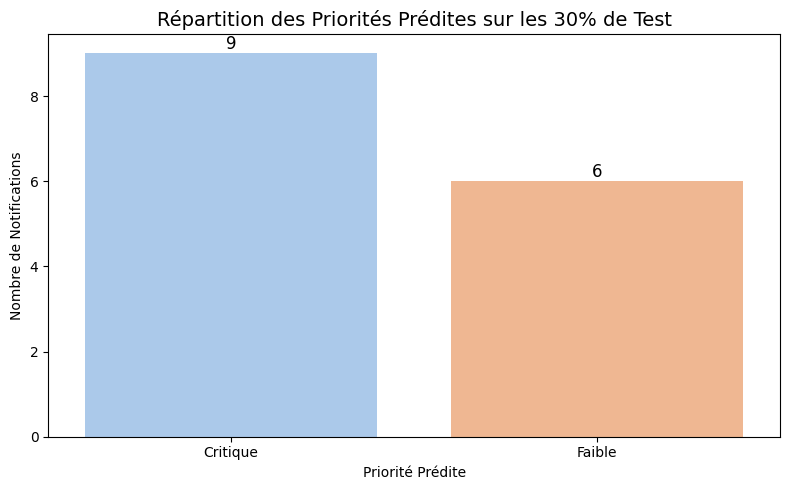

                                      Texte_Original Vraie_Priorité  \
0  Erreur dans l'importation des données des four...        Moyenne   
1  Équipement Machine de Remplissage (ID: E6450) ...       Critique   
2  Équipement Machine de Mélange Automatique (ID:...       Critique   
3  Équipement Pasteurisateur Lait (ID: E8731) dép...       Critique   
4  Erreur de format dans les informations de cont...         Faible   
5  Équipement Système de Nettoyage CIP (ID: E3003...         Faible   
6  Équipement Système de Nettoyage CIP (ID: E5496...       Critique   
7  Équipement Machine de Mélange Automatique (ID:...       Critique   
8  Équipement Ligne de Production Yaourt (ID: E71...       Critique   
9                         Description Pas disponible       Critique   

  Priorité_Prédit  
0          Faible  
1        Critique  
2        Critique  
3        Critique  
4          Faible  
5          Faible  
6        Critique  
7        Critique  
8        Critique  
9          Faible 

In [192]:
# 9. Prédiction finale sur les 30% (jeu de test)
print("\n📌 Prédiction finale sur les 30% du jeu de données :")

# Récupération du meilleur modèle
final_model = models[best_model]

# Prédictions
final_predictions = final_model.predict(X_test)

# Traduction des labels encodés vers les labels originaux
final_predictions_labels = le.inverse_transform(final_predictions)
true_labels = le.inverse_transform(y_test)

# Affichage des résultats sous forme de DataFrame
df_results = pd.DataFrame({
    "Texte_Original": X_test.index.map(lambda idx: df_notifications.loc[idx, 'description']),
    "Vraie_Priorité": true_labels,
    "Priorité_Prédit": final_predictions_labels
})
# 1. Créer une colonne de comptage
df_results['Priorité_Prédit'] = pd.Categorical(df_results['Priorité_Prédit'])

# 2. Visualisation avec seaborn
plt.figure(figsize=(8, 5))
sns.countplot(data=df_results, x='Priorité_Prédit', palette='pastel')

# 3. Ajout de valeurs sur les barres
for p in plt.gca().patches:
    plt.gca().annotate(f"{int(p.get_height())}", 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='bottom', fontsize=12)

# 4. Titres et labels
plt.title("Répartition des Priorités Prédites sur les 30% de Test", fontsize=14)
plt.xlabel("Priorité Prédite")
plt.ylabel("Nombre de Notifications")
plt.tight_layout()
plt.show()


# Affichage des premières lignes du tableau
print(df_results.head(10))


In [149]:
# 3. OBJECTIF RÉGRESSION (Matériaux)
req_materiaux = """
SELECT 
   [pk_material],
    [Material_ID],
    [Material_Name],
    [Type],
    [Unit_Price],
    [Stock_Initial],
    [Water_Consumption_per_Unit_liters],
    [Recycled_Packaging]
FROM [dbo].[Dimension_Matriaux]
WHERE [Water_Consumption_per_Unit_liters] IS NOT NULL
"""
# Récupération des données
df_materiaux= sql_to_df(req_materiaux)

# Affichage pour vérification
print(df_materiaux.head())


   pk_material Material_ID      Material_Name             Type  \
0            1        M062       Fromage râpé  Produit laitier   
1            2        M249  Eau déminéralisée  Produit laitier   
2            3        M131              Sel m  Produit laitier   
3            4        M132        Sucre blanc       Ingrédient   
4            5        M120  Crème pasteurisée       Ingrédient   

                     Unit_Price Stock_Initial  \
0                        122,31           361   
1                        357,78           356   
2  Prix Unitaire Pas disponible            40   
3                        470,11           405   
4                         63,05           174   

  Water_Consumption_per_Unit_liters Recycled_Packaging  
0                           3610,00                 NO  
1                           3560,00                 NO  
2                           4040,00                YES  
3                           1215,00                YES  
4                      

C:\Users\TAREK\AppData\Local\Temp\ipykernel_16596\424510669.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


In [150]:
# Vérification des premières lignes
print(df_materiaux.head())

# Vérification des types de colonnes
print(df_materiaux.dtypes)


   pk_material Material_ID      Material_Name             Type  \
0            1        M062       Fromage râpé  Produit laitier   
1            2        M249  Eau déminéralisée  Produit laitier   
2            3        M131              Sel m  Produit laitier   
3            4        M132        Sucre blanc       Ingrédient   
4            5        M120  Crème pasteurisée       Ingrédient   

                     Unit_Price Stock_Initial  \
0                        122,31           361   
1                        357,78           356   
2  Prix Unitaire Pas disponible            40   
3                        470,11           405   
4                         63,05           174   

  Water_Consumption_per_Unit_liters Recycled_Packaging  
0                           3610,00                 NO  
1                           3560,00                 NO  
2                           4040,00                YES  
3                           1215,00                YES  
4                      

In [151]:

import pandas as pd

# First convert relevant columns to string if they're not already
df_materiaux['Unit_Price'] = df_materiaux['Unit_Price'].astype(str)
df_materiaux['Water_Consumption_per_Unit_liters'] = df_materiaux['Water_Consumption_per_Unit_liters'].astype(str)

# Then perform the replacements and conversions
df_materiaux['Unit_Price'] = df_materiaux['Unit_Price'].str.replace(',', '.', regex=False)
df_materiaux['Unit_Price'] = pd.to_numeric(df_materiaux['Unit_Price'], errors='coerce')

df_materiaux['Water_Consumption_per_Unit_liters'] = df_materiaux['Water_Consumption_per_Unit_liters'].str.replace(',', '.', regex=False)
df_materiaux['Water_Consumption_per_Unit_liters'] = pd.to_numeric(df_materiaux['Water_Consumption_per_Unit_liters'], errors='coerce')

# Conversion de 'Stock_Initial' en entier
df_materiaux['Stock_Initial'] = pd.to_numeric(df_materiaux['Stock_Initial'], errors='coerce')

# Encodage binaire de la colonne 'Recycled_Packaging'
df_materiaux['Recycled_Packaging'] = df_materiaux['Recycled_Packaging'].map({'YES': 1, 'NO': 0})

# Vérification des types après conversion
print(df_materiaux.dtypes)

# Affichage pour vérifier les transformations
print(df_materiaux.head())

pk_material                            int64
Material_ID                           object
Material_Name                         object
Type                                  object
Unit_Price                           float64
Stock_Initial                        float64
Water_Consumption_per_Unit_liters    float64
Recycled_Packaging                   float64
dtype: object
   pk_material Material_ID      Material_Name             Type  Unit_Price  \
0            1        M062       Fromage râpé  Produit laitier      122.31   
1            2        M249  Eau déminéralisée  Produit laitier      357.78   
2            3        M131              Sel m  Produit laitier         NaN   
3            4        M132        Sucre blanc       Ingrédient      470.11   
4            5        M120  Crème pasteurisée       Ingrédient       63.05   

   Stock_Initial  Water_Consumption_per_Unit_liters  Recycled_Packaging  
0          361.0                             3610.0                 0.0  
1        

Type
produit laitier        439
ingrédient             408
Type Pas disponible    153
Name: count, dtype: int64


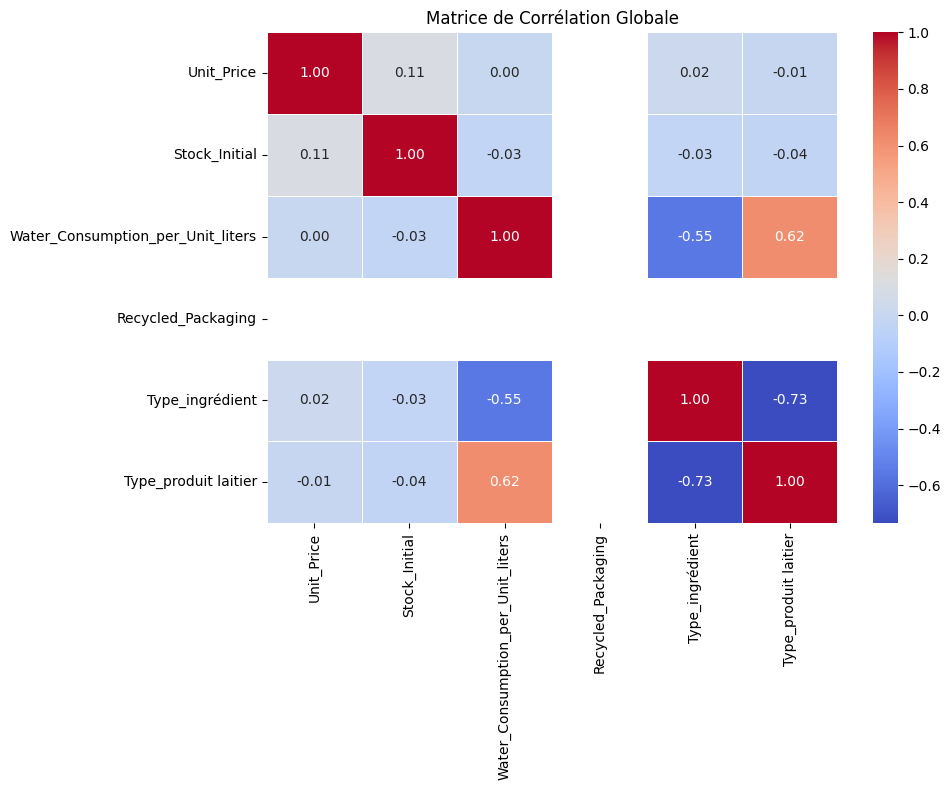


🔍 Corrélation des variables avec `Water_Consumption_per_Unit_liters`

Type_produit laitier    0.615689
Unit_Price              0.002306
Stock_Initial          -0.027788
Type_ingrédient        -0.553178
Recycled_Packaging           NaN
Name: Water_Consumption_per_Unit_liters, dtype: float64

✅ Variables recommandées (|corr| > 0.30) pour prédire `Water_Consumption_per_Unit_liters` :
 ['Type_produit laitier', 'Type_ingrédient']


In [154]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Remplacer les valeurs 'Produit' par 'produit laitier' et 'Ingr' par 'ingrédient'
df_materiaux['Type'] = df_materiaux['Type'].apply(
    lambda x: 'produit laitier' if x.startswith('Produit') else ('ingrédient' if x.startswith('Ingr') else x)
)

# 2. Vérification des changements
print(df_materiaux['Type'].value_counts())


# --- 1. Encodage des catégorielles ---
df_corr = df_materiaux.copy()

# Encode la variable binaire
df_corr['Recycled_Packaging'] = df_corr['Recycled_Packaging'].map({'YES': 1, 'NO': 0})

# One‑Hot pour 'Type'
df_corr = pd.get_dummies(df_corr, columns=['Type'], drop_first=True)

# Supprime les colonnes non numériques
to_drop = ['pk_material', 'Material_ID', 'Material_Name']
df_corr = df_corr.drop(columns=[c for c in to_drop if c in df_corr.columns])

# --- 2. Matrice de corrélation (heatmap) ---
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Matrice de Corrélation Globale")
plt.tight_layout()
plt.show()

# --- 3. Corrélation *par rapport* à la cible ---
target = 'Water_Consumption_per_Unit_liters'  # ou 'Unit_Price'
corr_with_target = df_corr.corr()[target].drop(target).sort_values(ascending=False)

print(f"\n🔍 Corrélation des variables avec `{target}`\n")
print(corr_with_target)

# --- 4. Sélection des features les plus corrélées ---
# Par exemple, on prend celles dont |corr| > 0.3
selected_features = corr_with_target[ corr_with_target.abs() > 0.30 ].index.tolist()
print(f"\n✅ Variables recommandées (|corr| > 0.30) pour prédire `{target}` :\n", selected_features)


✅ Aucun NaN dans X_scaled.
✅ Colonnes après encodage : ['pk_material', 'Material_ID', 'Material_Name', 'Unit_Price', 'Stock_Initial', 'Water_Consumption_per_Unit_liters', 'Recycled_Packaging', 'Type_Type Pas disponible', 'Type_ingrédient', 'Type_produit laitier']
🔍 Colonnes de type détectées : ['Type_Type Pas disponible', 'Type_ingrédient', 'Type_produit laitier']
🔎 Régression Linéaire
  ✅ R² : 0.420
  ✅ RMSE : 2133.360

🔎 Random Forest
  ✅ R² : 0.821
  ✅ RMSE : 1184.676

🔎 XGBoost
  ✅ R² : 0.810
  ✅ RMSE : 1220.696

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 4
[LightGBM] [Info] Start training from score 2874.963325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

C:\Users\TAREK\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\TAREK\AppData\Local\Temp\ipykernel_16596\3836819619.py:105: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\TAREK\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


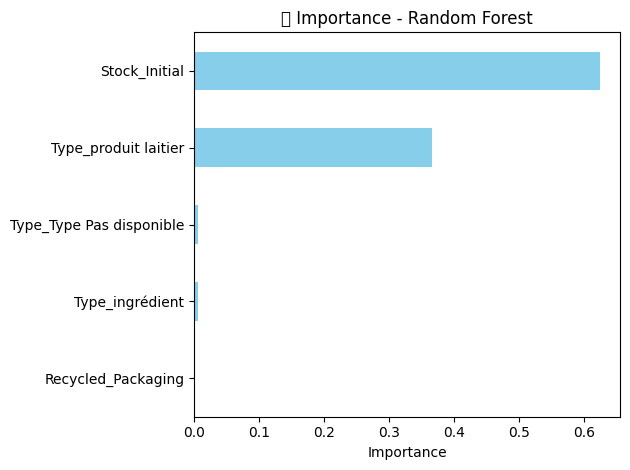

C:\Users\TAREK\AppData\Local\Temp\ipykernel_16596\3836819619.py:105: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\TAREK\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


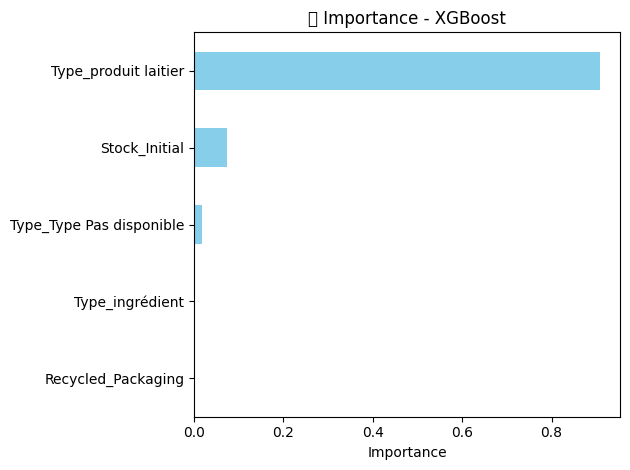

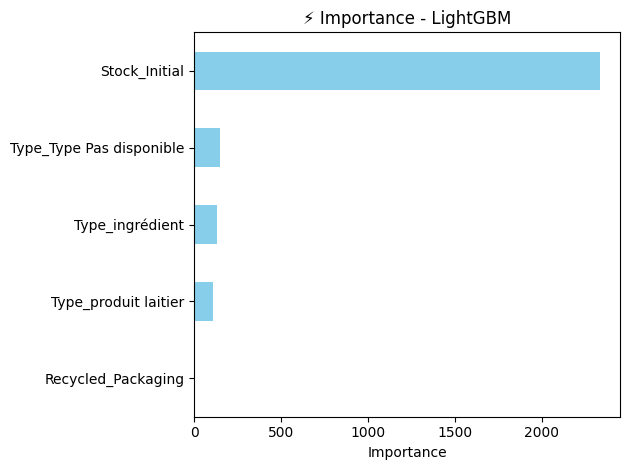

In [160]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- Nettoyage initial ---
df_materiaux_clean = df_materiaux.copy()

# Conversion de colonnes numériques
numeric_cols = ['Unit_Price', 'Stock_Initial', 'Water_Consumption_per_Unit_liters']
for col in numeric_cols:
    if df_materiaux_clean[col].dtype == object:
        df_materiaux_clean[col] = df_materiaux_clean[col].str.replace(',', '.').astype(float)

# Harmonisation des valeurs de la colonne 'Type'
df_materiaux_clean['Type'] = df_materiaux_clean['Type'].apply(
    lambda x: 'produit laitier' if str(x).startswith('Produit') else ('ingrédient' if str(x).startswith('Ingr') else x)
)

# Encodage binaire
df_materiaux_clean['Recycled_Packaging'] = df_materiaux_clean['Recycled_Packaging'].map({'YES': 1, 'NO': 0})


# One-hot encoding sur la colonne "Type"
df_materiaux_clean = pd.get_dummies(df_materiaux_clean, columns=["Type"])
# Remplissage des valeurs manquantes
df_materiaux_clean = df_materiaux_clean.fillna(0)  # Assure-toi de remplir toutes les valeurs manquantes avec 0

# Vérification des NaN avant l'entraînement
if np.isnan(X_scaled).sum() > 0:
    print(f"❌ Il y a encore des NaN dans X_scaled.")
else:
    print(f"✅ Aucun NaN dans X_scaled.")


# Vérifie les colonnes générées
print("✅ Colonnes après encodage :", df_materiaux_clean.columns.tolist())

# Recherche des colonnes 'Type_*'
type_cols = [col for col in df_materiaux_clean.columns if col.startswith("Type_")]
print("🔍 Colonnes de type détectées :", type_cols)

# Construction dynamique des features
features = type_cols + [ 'Stock_Initial', 'Recycled_Packaging']
target = 'Water_Consumption_per_Unit_liters'



# Remplissage des valeurs manquantes
# Sécurité supplémentaire : remplir tous les NaN par la moyenne ou 0 (selon le type)
df_materiaux_clean = df_materiaux_clean.fillna(df_materiaux_clean.mean(numeric_only=True))


# Création du DataFrame final
df = df_materiaux_clean[features + [target]]

# Séparation X / y
X = df.drop(columns=[target])
y = df[target]

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modèles
models = {
    "Régression Linéaire": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Entraînement & Évaluation
def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"🔎 {name}")
    print(f"  ✅ R² : {r2_score(y_test, y_pred):.3f}")
    print(f"  ✅ RMSE : {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
    print("")
    return model, y_pred

fitted_models = {}
for name, model in models.items():
    fitted_model, _ = evaluate_model(name, model)
    fitted_models[name] = fitted_model

# Importance des variables
def plot_feature_importance(model, feature_names, title):
    importance = model.feature_importances_
    feat_df = pd.Series(importance, index=feature_names).sort_values()
    feat_df.plot(kind='barh', title=title, color='skyblue')
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

plot_feature_importance(fitted_models["Random Forest"], X.columns, "🌲 Importance - Random Forest")
plot_feature_importance(fitted_models["XGBoost"], X.columns, "🚀 Importance - XGBoost")
plot_feature_importance(fitted_models["LightGBM"], X.columns, "⚡ Importance - LightGBM")


In [23]:
# 4. OBJECTIF SÉRIES TEMPORELLES (Émissions CO2)
req_emissions = """
SELECT 
    d.[FullDate],
    f.[CO2_Emissions_kg],
    e.[equipment_name],
    l.[location_name]
FROM [dbo].[Fact_Ressource] f
JOIN [dbo].[Dimension_Date] d ON f.[FK_Date] = d.[DateID]
JOIN [dbo].[Dimension_Equipement] e ON f.[FK_Equipement] = e.[PK_Equipement]
JOIN [dbo].[Dimension_Location] l ON f.[FK_Location] = l.[Pk_Location]
WHERE f.[CO2_Emissions_kg] IS NOT NULL
ORDER BY d.[FullDate]
"""
# Récupération des données
df_emissions= sql_to_df(req_emissions)

# Affichage pour vérification
print(df_emissions)

      FullDate CO2_Emissions_kg                 equipment_name  \
0   2000-01-01      240,3950683  Machine d'Inspection Visuelle   
1   2000-01-01      879,5585312            Pasteurisateur Lait   
2   2000-01-01      827,5576133  Machine d'Inspection Visuelle   
3   2000-01-01        140,70456  Machine d'Inspection Visuelle   
4   2000-01-01      588,4264748  Machine d'Inspection Visuelle   
..         ...              ...                            ...   
609 2000-01-01      692,8242685            Machine d'Emballage   
610 2000-01-01      113,9109549  Machine d'Inspection Visuelle   
611 2000-01-01      874,6575249            Pasteurisateur Lait   
612 2000-01-01      395,8764493      Équipement Pas disponible   
613 2000-01-01      191,3243886  Machine d'Inspection Visuelle   

       location_name  
0         Usine Cenk  
1             Usinel  
2             Usinem  
3    Atelier Pasteud  
4    Atelier Pasteuq  
..               ...  
609      Usine Gabès  
610      Usine Gabès  


C:\Users\TAREK\AppData\Local\Temp\ipykernel_17284\424510669.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


In [5]:
print(df_emissions.columns)


Index(['FullDate', 'CO2_Emissions_kg', 'equipment_name', 'location_name'], dtype='object')


C:\Users\TAREK\AppData\Local\Temp\ipykernel_17284\1681378858.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2000-01-01', periods=100, freq='M')


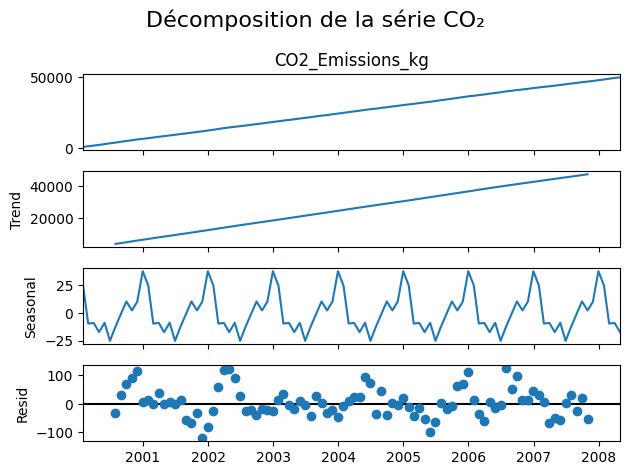

C:\Users\TAREK\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\TAREK\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\TAREK\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


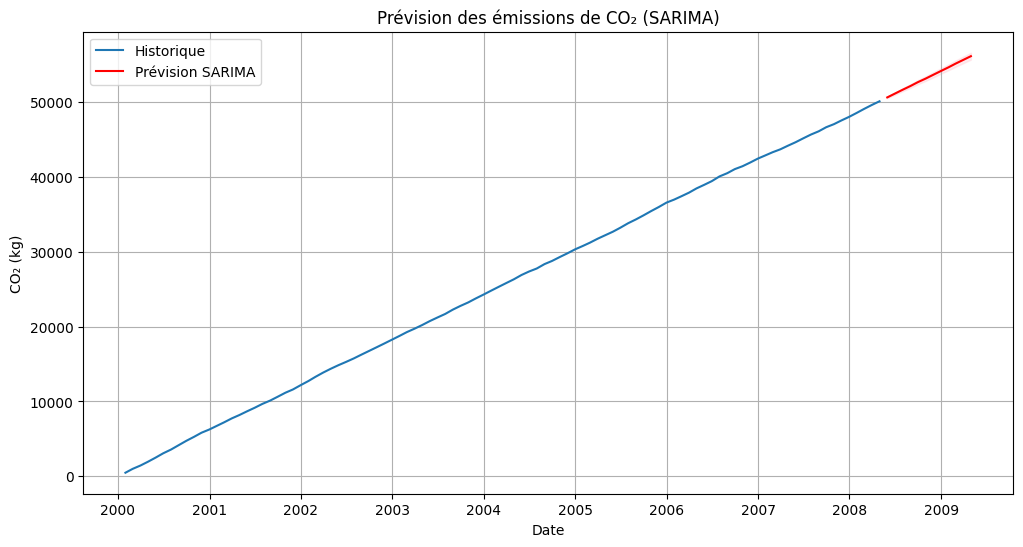

p-value : 0.568


C:\Users\TAREK\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\TAREK\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\TAREK\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\TAREK\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\TAREK\AppData\R

RMSE: 57.83 kg


C:\Users\TAREK\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

# 1. Chargement des données avec les bonnes colonnes
# Remplace ceci par ton propre chargement si tu as un fichier CSV ou Excel
# Exemple : df = pd.read_csv("your_file.csv", parse_dates=["FullDate"])
# Ici, je génère un exemple
dates = pd.date_range(start='2000-01-01', periods=100, freq='M')
emissions = np.random.normal(loc=500, scale=50, size=100).cumsum()
df = pd.DataFrame({'FullDate': dates, 'CO2_Emissions_kg': emissions})

# Conversion de FullDate en index temporel
df['FullDate'] = pd.to_datetime(df['FullDate'])
df.set_index('FullDate', inplace=True)

# 2. Décomposition
decomposition = seasonal_decompose(df['CO2_Emissions_kg'], model='additive', period=12)
decomposition.plot()
plt.suptitle("Décomposition de la série CO₂", fontsize=16)
plt.tight_layout()
plt.show()

# 3. Modèle SARIMA
model = SARIMAX(df['CO2_Emissions_kg'], order=(2, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

# 4. Prévision sur 12 mois
forecast = results.get_forecast(steps=12)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# 5. Affichage
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['CO2_Emissions_kg'], label='Historique')
plt.plot(forecast_values.index, forecast_values, color='red', label='Prévision SARIMA')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Prévision des émissions de CO₂ (SARIMA)')
plt.xlabel('Date')
plt.ylabel('CO₂ (kg)')
plt.legend()
plt.grid()
plt.show()

# Test de stationnarité
result = adfuller(df['CO2_Emissions_kg'])
print(f"p-value : {result[1]:.3f}")

# 6. Backtesting
train_size = int(len(df) * 0.8)
train, test = df['CO2_Emissions_kg'][:train_size], df['CO2_Emissions_kg'][train_size:]

history = list(train)
predictions = []

for t in range(len(test)):
    model = SARIMAX(history, order=(2, 1, 1), seasonal_order=(1, 1, 1, 12))
    results = model.fit(disp=False)
    yhat = results.forecast()[0]
    predictions.append(yhat)
    history.append(test.iloc[t])

rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse:.2f} kg')


In [27]:
import pickle

# Exemple : modèle fictif
model = {'example': 'This is a sample model'}

# Sauvegarder le modèle
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Le modèle a été enregistré sous 'model.pkl'.")

Le modèle a été enregistré sous 'model.pkl'.


In [29]:

from IPython.display import FileLink

# Afficher un lien de téléchargement pour le fichier model.pkl
FileLink('model.pkl')

c:\Users\TAREK\Downloads\model.pkl

C:\Users\TAREK\AppData\Local\Temp\ipykernel_17284\3146500517.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2000-01-01', periods=100, freq='M')


p-value : 0.039
Stationnarité après transformation : True


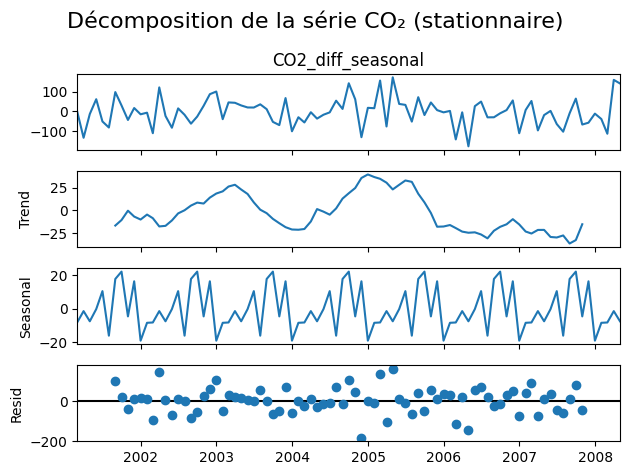

C:\Users\TAREK\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\TAREK\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\TAREK\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\TAREK\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\TAREK\AppData\Roam

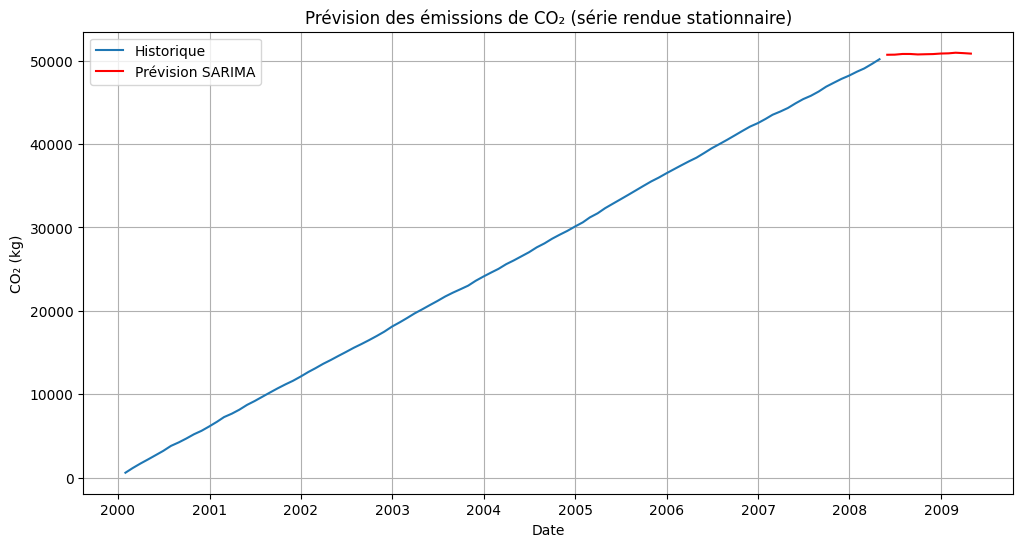

C:\Users\TAREK\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\TAREK\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\TAREK\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\TAREK\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization f

RMSE (série stationnaire): 76.76


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

# 1. Génération de données simulées (100 mois)
dates = pd.date_range(start='2000-01-01', periods=100, freq='M')
emissions = np.random.normal(loc=500, scale=50, size=100).cumsum()
df = pd.DataFrame({'Date': dates, 'CO2_kg': emissions}).set_index('Date')

# 2. Transformation pour stationnarité avec gestion des NaN
df['CO2_diff'] = df['CO2_kg'].diff()  # 1ère différence
df['CO2_diff_seasonal'] = df['CO2_diff'].diff(12)  # Différence saisonnière

# Suppression des NaN créés par les différences
df_clean = df.dropna(subset=['CO2_diff_seasonal'])

# Vérification de la stationnarité
def check_stationarity(series):
    result = adfuller(series.dropna())  # S'assurer qu'il n'y a pas de NaN
    print(f"p-value : {result[1]:.3f}")
    return result[1] < 0.05

print("Stationnarité après transformation :", check_stationarity(df_clean['CO2_diff_seasonal']))

# 3. Décomposition de la série stationnaire
decomposition = seasonal_decompose(df_clean['CO2_diff_seasonal'], model='additive', period=12)
decomposition.plot()
plt.suptitle("Décomposition de la série CO₂ (stationnaire)", fontsize=16)
plt.tight_layout()
plt.show()

# 4. Modélisation SARIMA sur données stationnaires
model = SARIMAX(df_clean['CO2_diff_seasonal'], 
                order=(2, 0, 1),  # d=0 car déjà différencié
                seasonal_order=(1, 0, 1, 12))  # D=0 car déjà différencié
results = model.fit()

# 5. Prévision et inversion des différences
forecast = results.get_forecast(steps=12)
forecast_values = forecast.predicted_mean

# Reconstruction de la série originale (méthode simplifiée)
last_value = df['CO2_kg'].iloc[-1]
last_diff = df['CO2_diff'].iloc[-1]
forecast_original = [last_value + last_diff + forecast_values[0]]  # Premier point

for i in range(1, len(forecast_values)):
    forecast_original.append(forecast_original[-1] + forecast_values[i])

# 6. Affichage
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['CO2_kg'], label='Historique')
forecast_index = pd.date_range(start=df.index[-1], periods=13, freq='M')[1:]
plt.plot(forecast_index, forecast_original, color='red', label='Prévision SARIMA')
plt.title('Prévision des émissions de CO₂ (série rendue stationnaire)')
plt.xlabel('Date')
plt.ylabel('CO₂ (kg)')
plt.legend()
plt.grid()
plt.show()

# 7. Évaluation
train_size = int(len(df_clean) * 0.8)
train, test = df_clean['CO2_diff_seasonal'][:train_size], df_clean['CO2_diff_seasonal'][train_size:]

history = list(train)
predictions = []

for t in range(len(test)):
    model = SARIMAX(history, order=(2, 0, 1), seasonal_order=(1, 0, 1, 12))
    results = model.fit(disp=False)
    yhat = results.forecast()[0]
    predictions.append(yhat)
    history.append(test.iloc[t])

rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE (série stationnaire): {rmse:.2f}')

In [169]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Copie pour éviter de modifier l'original
df_model = df_fournisseurs.copy()

# 1. Encodage des colonnes catégorielles (string → int)
label_cols = df_model.select_dtypes(include=['object']).columns
for col in label_cols:
    df_model[col] = LabelEncoder().fit_transform(df_model[col].astype(str))

# 2. Séparer features et target
X = df_model.drop('renewable_energy_percentage', axis=1).values
y = df_model['renewable_energy_percentage'].values

# 3. Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 5. Conversion en tenseurs
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 6. Définition du modèle
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.drop1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.drop1(x)
        x = torch.relu(self.fc2(x))
        x = self.drop2(x)
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# 7. Entraînement
model = Net(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()

    # Afficher la perte à chaque 10 époques
    if epoch % 10 == 0:
        print(f"Époque {epoch+1}, Perte : {loss.item():.4f}")

# 8. Prédiction
model.eval()
with torch.no_grad():
    preds = model(X_test_t).numpy().flatten()

mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)

# Affichage du RMSE et des prédictions vs réelles
print(f"✅ RMSE du modèle deep learning : {rmse:.3f}")

print("Exemples de prédictions vs réelles:")
for i in range(5):  # Afficher les 5 premières prédictions
    print(f"Prédiction : {preds[i]:.2f}, Réelle : {y_test[i]:.2f}")


Époque 1, Perte : 2966.3015
Époque 11, Perte : 2931.9258
Époque 21, Perte : 2856.0854
Époque 31, Perte : 2661.4131
Époque 41, Perte : 2292.8052
Époque 51, Perte : 1702.6676
Époque 61, Perte : 999.5949
Époque 71, Perte : 749.8569
Époque 81, Perte : 607.9761
Époque 91, Perte : 489.3751
✅ RMSE du modèle deep learning : 26.397
Exemples de prédictions vs réelles:
Prédiction : 60.16, Réelle : 65.39
Prédiction : 47.98, Réelle : 32.09
Prédiction : 28.69, Réelle : 38.62
Prédiction : 36.91, Réelle : 19.42
Prédiction : 32.48, Réelle : 8.67


In [37]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm

# --- Config ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "E:\data"  # Structure: data/ecologique/, data/polluant/
MODEL_PATH = "resnet18_smoke_detector.pth"
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 2
LR = 1e-4

# --- Data Augmentation ---
train_tf = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# --- Chargement des données ---
train_data = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=train_tf)
val_data   = datasets.ImageFolder(os.path.join(DATA_DIR, 'val'), transform=val_tf)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=BATCH_SIZE)

# --- Modèle ---
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# --- Entraînement ---
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc=f"Époque {epoch+1}/{EPOCHS}"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"Train Loss: {running_loss:.4f}, Accuracy: {acc:.2%}")

# --- Sauvegarde ---
torch.save(model.state_dict(), MODEL_PATH)
print(f"✅ Modèle sauvegardé : {MODEL_PATH}")


<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
C:\Users\TAREK\AppData\Local\Temp\ipykernel_17284\329321084.py:10: SyntaxWarning: invalid escape sequence '\d'
  DATA_DIR = "E:\data"  # Structure: data/ecologique/, data/polluant/
Époque 1/10: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Train Loss: 0.8405, Accuracy: 50.00%


Époque 2/10: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Train Loss: 0.6982, Accuracy: 50.00%


Époque 3/10: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Train Loss: 0.5320, Accuracy: 66.67%


Époque 4/10: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Train Loss: 0.1905, Accuracy: 100.00%


Époque 5/10: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Train Loss: 0.1774, Accuracy: 100.00%


Époque 6/10: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Train Loss: 0.2063, Accuracy: 100.00%


Époque 7/10: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Train Loss: 0.0519, Accuracy: 100.00%


Époque 8/10: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Train Loss: 0.0818, Accuracy: 100.00%


Époque 9/10: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Train Loss: 0.0557, Accuracy: 100.00%


Époque 10/10: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

Train Loss: 0.0888, Accuracy: 100.00%
✅ Modèle sauvegardé : resnet18_smoke_detector.pth


In [38]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image

# -------------------------
# 1) Configuration
# -------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "resnet18_smoke_detector.pth"  # Assure-toi que ce chemin est correct
CLASS_NAMES = ['Écologique', 'Polluant']    # Assure-toi que l'ordre correspond à ton entraînement

# -------------------------
# 2) Transformations pour l'inférence
# -------------------------
val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# -------------------------
# 3) Chargement du modèle
# -------------------------
def load_model():
    model = models.resnet18(pretrained=True)  # On utilise les poids ImageNet
    model.fc = nn.Linear(model.fc.in_features, len(CLASS_NAMES))
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.to(DEVICE).eval()
    return model

# -------------------------
# 4) Classification d'une image
# -------------------------
def classify_image(model, image_path: str) -> str:
    img = Image.open(image_path).convert("RGB")
    x = val_tf(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        outputs = model(x)
        probs = torch.softmax(outputs, dim=1)
        pred_index = probs.argmax(dim=1).item()
        confidence = probs[0][pred_index].item()

    label = CLASS_NAMES[pred_index]
    return f"{label} (confiance : {confidence:.2%})"

# -------------------------
# 5) Traitement de plusieurs images
# -------------------------
if __name__ == '__main__':
    IMAGE_PATHS = [
        r"C:\Users\TAREK\Downloads\image3.jpg",
        r"C:\Users\TAREK\Downloads\image 2.jpg",
        r"C:\Users\TAREK\Downloads\image1.jpg",
        r"C:\Users\TAREK\Downloads\images5.jpg",
        r"C:\Users\TAREK\Downloads\image7.jpg",
        r"C:\Users\TAREK\Downloads\images8.jpg"
       

    ] 


    model = load_model()

    for path in IMAGE_PATHS:
        if not os.path.isfile(path):
            print(f"⚠️ Fichier non trouvé : {path}")
            continue
        result = classify_image(model, path)
        print(f"{os.path.basename(path)} → {result}")


image3.jpg → Écologique (confiance : 100.00%)
image 2.jpg → Écologique (confiance : 100.00%)
image1.jpg → Polluant (confiance : 80.15%)
images5.jpg → Polluant (confiance : 53.58%)
image7.jpg → Écologique (confiance : 84.37%)
images8.jpg → Polluant (confiance : 98.05%)
